<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/MGMT687_HW5_Lichen_Maov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q1 Predictive Modeling (XGBoost Pipeline)**


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from time import perf_counter
import joblib

In [4]:
#fit regression model
t0 = perf_counter()

#step1 read data and define target
df = pd.read_csv("HousingPriceDaejeonTrainValidate.csv")
TARGET = "Condominium price"

#step2 pre-processing
df = df.drop_duplicates()
df = df[df[TARGET].notna()].copy()
y = np.log1p(df[TARGET].values)
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

#step3. split train and validation data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=26
)
X_train_t = preprocess.fit_transform(X_train)
X_val_t   = preprocess.transform(X_val)

#step3 define XGBoost model
xgb = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=26,
    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=50,
)

xgb.fit(
    X_train_t, y_train,
    eval_set=[(X_val_t, y_val)],
    verbose=False
)

#step5 validation
val_pred_log = xgb.predict(X_val_t)
val_pred = np.expm1(val_pred_log)
val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(val_true, val_pred))
mae  = mean_absolute_error(val_true, val_pred)
r2   = r2_score(val_true, val_pred)

print(f"[Validation] RMSE: {rmse:,.0f}")
print(f"[Validation] MAE : {mae:,.0f}")
print(f"[Validation] R^2 : {r2:.4f}")
print("Best boosting round (0-indexed):", xgb.best_iteration)

#step6. optimization based on validation
best_n_estimators = int(xgb.best_iteration) + 1
preprocess_final = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

X_all_t = preprocess_final.fit_transform(X)
xgb_final = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=best_n_estimators,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=26,
    n_jobs=-1
)
xgb_final.fit(X_all_t, y)

#step7 save the model for testing
model_bundle = {"preprocess": preprocess_final, "model": xgb_final}
joblib.dump(model_bundle, "xgb_house_price_model.joblib")
t1 = perf_counter()
print(f"Training time : {t1-t0:.2f} sec")

[Validation] RMSE: 1,368
[Validation] MAE : 819
[Validation] R^2 : 0.9815
Best boosting round (0-indexed): 1087
Training time : 19.99 sec


In [5]:
#test result
import pandas as pd
import numpy as np
import joblib
from time import perf_counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
t1 = perf_counter()

#step1 recall saved model
model_bundle = joblib.load("xgb_house_price_model.joblib")
preprocess = model_bundle["preprocess"]
model = model_bundle["model"]

#step2 test on test dataset
test_df = pd.read_csv("HousingPriceDaejeonTest.csv")
print(test_df.shape)
test_df.head()
TARGET = "Condominium price"
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].values

#step3. transform and predict result
X_test_t = preprocess.transform(X_test)
pred_log = model.predict(X_test_t)
pred_price = np.expm1(pred_log)
rmse = np.sqrt(mean_squared_error(y_test, pred_price))
mae = mean_absolute_error(y_test, pred_price)
r2 = r2_score(y_test, pred_price)

print("Test RMSE:", rmse)
print("Test MAE :", mae)
print("Test R2  :", r2)
t2 = perf_counter()
print(f"Prediction time: {t2-t1:.2f} sec")


(4223, 28)
Test RMSE: 1167.197926660256
Test MAE : 762.58544921875
Test R2  : 0.9861628413200378
Prediction time: 0.29 sec


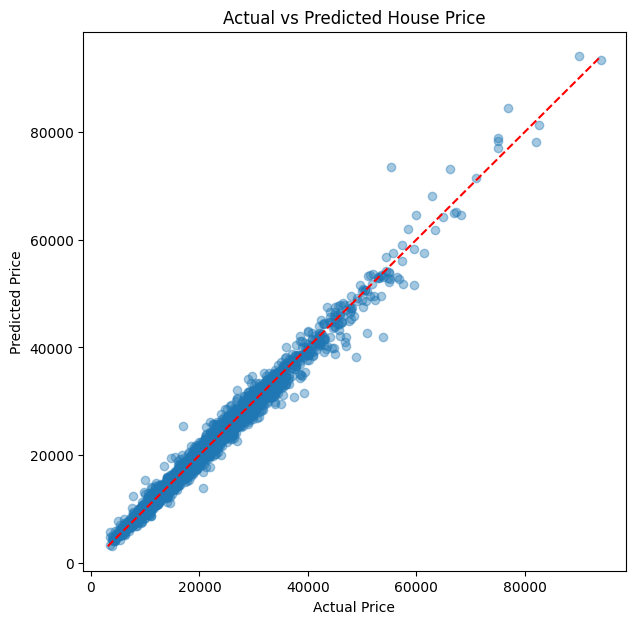

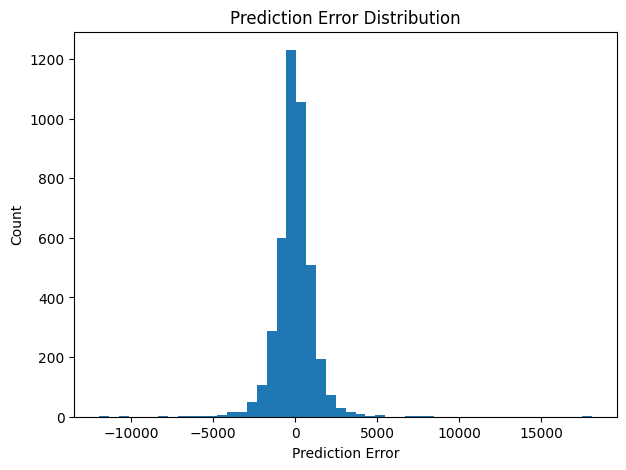

In [8]:
#visiualize the result
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_price, alpha=0.4)
max_val = max(y_test.max(), pred_price.max())
min_val = min(y_test.min(), pred_price.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Price")
plt.show()
errors = pred_price - y_test

plt.figure(figsize=(7,5))
plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

# **Evaluate and discuss your model performance:**

As shown above in both the results and the figure, the XGBoost model fits the data well and achieves strong predictive performance in estimating condominium prices:

Test RMSE: 1167.20

Test MAE: 762.59

Test R²: 0.9862

The Test RMSE and MAE indicate that the predictions are reasonably close to the actual prices, and the high R² further confirms strong explanatory power. Compared to a simple baseline expectation, the model successfully captures more complex relationships (such as non-linear effects and multicollinearity) between the explanatory variables and the final housing prices.

When designing this model, I used a validation dataset to determine the optimal number of estimators with early stopping to prevent overfitting. The training process stops once the improvement in validation performance becomes negligible. The validation R² (0.9815) is close to the test R², which suggests that the model generalizes well to unseen data.

On the other hand, the model still has some limitations. For example, confounding features or omitted variables may still exist and may not be fully represented in the training and testing datasets.

# **Q2.a**

For this problem, I will use code to draw a shap waterfall figure first, then explain and analysis the problem.

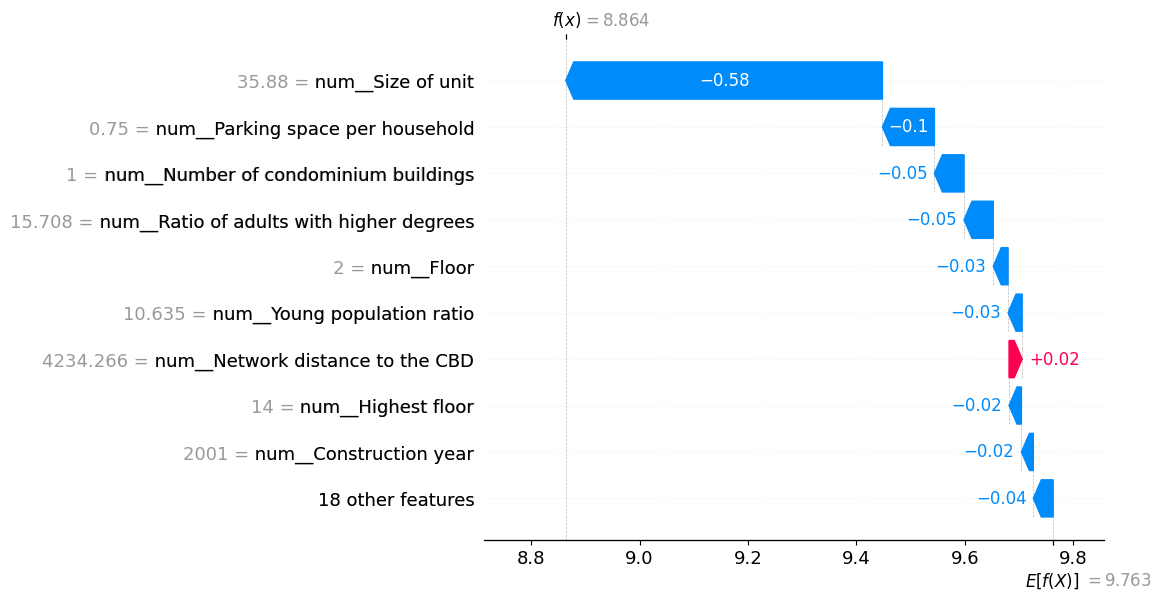

In [3]:
# code for figure
import shap
import pandas as pd
import shap
import pandas as pd
import joblib

# recall model and test database
model_bundle = joblib.load("xgb_house_price_model.joblib")
preprocess = model_bundle["preprocess"]
xgb = model_bundle["model"]
test_df = pd.read_csv("HousingPriceDaejeonTest.csv")
TARGET = "Condominium price"
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

# mapping feature name back to dataset column name
X_test_t_df = pd.DataFrame(
    preprocess.transform(X_test),
    columns=preprocess.get_feature_names_out(),
    index=X_test.index
)

# SHAP visiualization
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_t_df)
shap.plots.waterfall(shap_values[0])

From the SHAP waterfall figure above, we can see how the variables contribute to the price for the first transaction record. The prediction starts from the base value (the average prediction of the dataset) and is then adjusted according to each feature’s contribution to reach the final predicted price.

In the SHAP bar chart, each bar represents how a feature contributes to the prediction (red bars indicate positive contributions and blue bars indicate negative contributions). Since the model was trained using log-transformed prices, all SHAP contributions are interpreted on the **log-price scale**. The first nine features can be treated as the most significant contributors in this case.

For this transaction, note that the predicted condominium price is:

f(x)=8.884, and E(f(x))=9.763 (which means there is a 8.884-9.763=-0.879 in log difference)

Other feature values, such as Size of unit (−0.58), Parking space per household (−0.10), and Number of condominium buildings (−0.05), together with additional features, explain the gap between f(x) and E(f(x)).

This indicates that the predicted value is lower than the base value, suggesting that the overall characteristics of this condominium reduce its estimated price compared to the average level.

*   Most features have negative contributions, while Network distance to the CBD is the only significant positive contributor. However, its magnitude (+0.02) is relatively small compared to the other significant features.

*   For this individual case, Size of unit plays a dominant role (−0.58 out of −0.879 under this transaction) in driving the prediction downward.

Overall, the plot clearly illustrates how different property characteristics combine to determine the final predicted price for this individual transaction.



# **Q2.b**

For this question I will start with code to make a summary visualization (beeswarm figure) of SHAP, then explain and analysis.

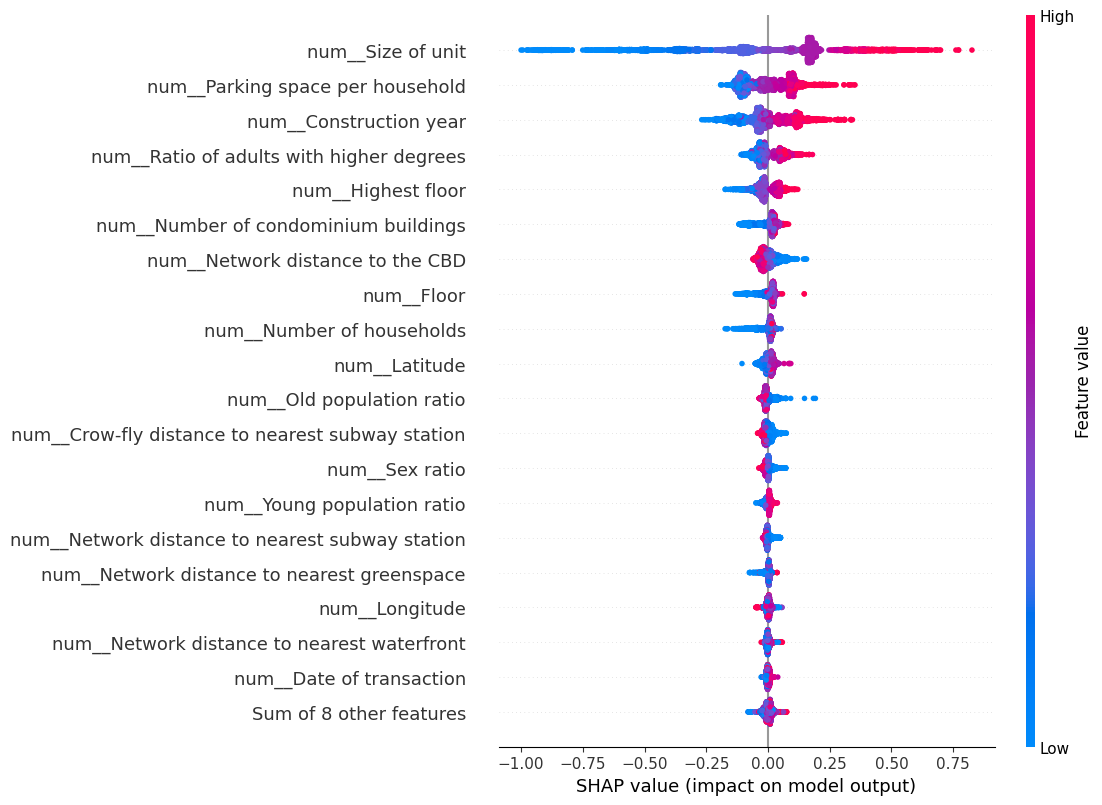

In [4]:
#code for beeswarm
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt

#recall trained model bundle and test dataset
model_bundle = joblib.load("xgb_house_price_model.joblib")
preprocess = model_bundle["preprocess"]
xgb = model_bundle["model"]
test_df = pd.read_csv("HousingPriceDaejeonTest.csv")
TARGET = "Condominium price"
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

#transform & feature name mapping
X_test_t_df = pd.DataFrame(
    preprocess.transform(X_test),
    columns=preprocess.get_feature_names_out(),
    index=X_test.index
)

#SHAP explain and visiualization
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_t_df)
shap.plots.beeswarm(shap_values, max_display=20)

The SHAP summary figure above provides a global explanation of how the XGBoost model predicts condominium prices across the dataset. In this figure:


1.   Features are ranked by their overall impact on predictions, with the most important features shown at the top (wider spread of dots = stronger influence on condominium prices, also in log scale).
2.   Each dot represents one transaction.
3.   The horizontal position indicates whether a feature increases (right) or decreases (left) the predicted price.
4.   Color shows the feature value (red = high, blue = low).

Several key points can be concluded from this global explanation figure:

*   **Similiar to the conclusion of Q2.a**. Size of unit has the strongest impact on prices, and Network distance to the CBD shows a significant positive influence.
*   **The direction of impact for some features is economically intuitive.** For example, higher values of Size of unit generally increase predicted prices, while lower values decrease them.
*   Other features such as parking space per household, construction year, and education level also influence predictions but to a smaller extent. Features near the bottom have minimal impact as their SHAP values are close to zero.
*   **Clustered data**. We observe clustered SHAP values for several features (Size of unit, Parking space per household, construction year,Highest floor and so on). This may reflect the piecewise nature of tree-based models like XGBoost, where similar feature ranges produce similar contribution levels. It may also suggest segmentation in the housing market, where properties with similar characteristics fall into distinct pricing groups.

Overall, the plot shows which features are most influential and how they affect price predictions across transactions. Since the model was trained on log-transformed prices, all SHAP values are interpreted in the log-price scale.






# **Q2.c**
For this question I will start with code to make a summary visualization (beeswarm figure) of SHAP, then explain and analysis.

Using feature: num__Size of unit


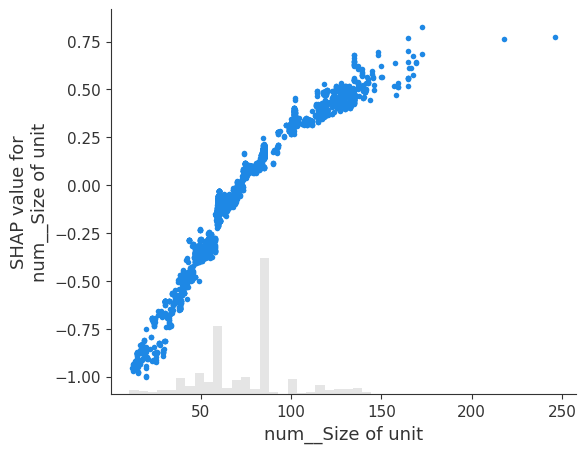

In [6]:
#visualization that reveals the relationship
import pandas as pd
import shap

#recall model and dataset
model_bundle = joblib.load("xgb_house_price_model.joblib")
preprocess = model_bundle["preprocess"]
xgb = model_bundle["model"]
test_df = pd.read_csv("HousingPriceDaejeonTest.csv")
TARGET = "Condominium price"
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]  # not required for SHAP plot, but kept for completeness

#transform & mapping feature name
X_test_t_df = pd.DataFrame(
    preprocess.transform(X_test),
    columns=preprocess.get_feature_names_out(),
    index=X_test.index
)

#SHAP
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_t_df)

#pick size of unit then visiualize
size_candidates = [c for c in X_test_t_df.columns if "Size of unit" in c]
if not size_candidates:
    raise ValueError("Could not find 'Size of unit' in transformed feature names. Print X_test_t_df.columns to inspect.")
size_feat = size_candidates[0]
print("Using feature:", size_feat)

shap.plots.scatter(shap_values[:, size_feat])

The SHAP dependence figure above illustrates the relationship between unit size (x-axis) and its contribution to the model’s predicted condominium price (y-axis, shown as SHAP values on the log-price scale).

From the figure, we can observe a clear positive relationship between unit size and its SHAP value. This observation is consistent with the observation in Q2.b: smaller units tend to have negative SHAP values, meaning they decrease the predicted price relative to the average. As unit size increases, the SHAP values become positive, indicating that larger units increase the predicted price. The curved pattern also reflects the piecewise structure of the XGBoost model.

The clustering pattern observed for unit size in Q2.b is further explained here. The area-based histogram shows that most data points are concentrated around unit sizes of approximately x=55 and x=80. This indicates that a large proportion of transactions fall within these common size ranges. Because many properties share similar unit sizes, their SHAP contributions are also clustered in similar regions. This reflects both the underlying distribution of the dataset and the piecewise nature of the XGBoost model, where similar feature values tend to produce similar contribution levels.

Overall, this visualization demonstrates how the model associates unit size with predicted price. **However**, **it reflects correlations learned by the model rather than causal effects**. Since the model was trained on log-transformed prices, all SHAP values are interpreted on the log-price scale.

# **Q3**

Definitely not. As mentioned in this week’s lecture, SHAP reflects correlation rather than causation. It is an analytical tool used to understand the contribution of each feature to the model’s prediction, not to establish a causal effect of a feature on the outcome. In this context, we cannot conclude that the market price will increase by the exact amount represented by a SHAP contribution.

SHAP values explain how the model uses features to generate predictions based on patterns learned from historical data. They capture associations between features and predicted prices rather than causal relationships. Although the model shows that larger unit sizes are associated with higher predicted prices, this does not guarantee that increasing unit size alone would produce the same increase in actual market prices.

Furthermore, external or confounding factors—such as location characteristics, macroeconomic conditions, or events like a pandemic—may also influence housing prices. Therefore, SHAP analysis helps interpret the model’s behavior but should not be used to draw definitive causal conclusions.

